In [1]:
from zipfile import ZipFile
from typing import List, Tuple, Callable

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import pywt
from scipy.stats import kurtosis, entropy
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tsfel import feature_extraction as ft

import os
import sys
sys.path.append('../')
from vibrodiagnostics import (
    mafaulda,
    extraction,
    selection
)

plt.rcParams.update({'font.size': 14})
WT_COLUMNS_EXCLUDE = {'fault', 'severity', 'seq', 'rpm', 'axis', 'feature'}

In [2]:
METRICS = ['C', 'F', 'MI']
METRIC = METRICS[0]
GENERATE = False

In [3]:
PATH = '../datasets'
FEATURES_PATH = os.path.join(PATH, 'features')
DATASET_PATH = os.path.join(PATH, 'MAFAULDA.zip')
FEATURES = {
    'TD': os.path.join(FEATURES_PATH, 'MAFAULDA_TD.csv'),
    'FD': os.path.join(FEATURES_PATH, 'MAFAULDA_FD.csv'),
    'WT': os.path.join(FEATURES_PATH, 'MAFAULDA_WT.csv')
}
PARTS = 1

In [4]:
def calc_feature_selection_metric(
        fmetric: Callable,
        dataset: pd.DataFrame,
        columns: List[str]) -> pd.DataFrame:

    m = fmetric(dataset[columns], dataset['fault']) 
    if isinstance(m, tuple):
        m = m[0]
    return (pd.DataFrame(list(zip(columns, m)), columns=['feature', 'stat'])
                .set_index('feature')
                .sort_values(by='stat', ascending=False))
    

def calc_corr_stat(dataset, columns):
    return calc_feature_selection_metric(selection.corr_classif, dataset, columns)


def calc_f_stat(dataset, columns):
    return calc_feature_selection_metric(f_classif, dataset, columns)


def calc_mutual_information(dataset, columns):
    return calc_feature_selection_metric(mutual_info_classif, dataset, columns)

In [5]:
if METRIC == 'C':
    calc_func = calc_corr_stat
    title = 'Correlation'
elif METRIC == 'F':
    calc_func = calc_f_stat
    title = 'F statistic'
elif METRIC == 'MI':
    calc_func = calc_mutual_information
    title = 'Mutual information'

In [6]:
def normalize_features(features, columns):
    standard_transformer = Pipeline(steps=[('standard', StandardScaler())])
    minmax_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])
    preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('std', standard_transformer, columns)
        ],
        verbose_feature_names_out=False
    )
    features_normalized = preprocessor.fit_transform(features)
    features_normalized = pd.DataFrame(
        features_normalized,
        columns=preprocessor.get_feature_names_out()
    )
    return features_normalized


def calc_score_in_wpd_features(src, func):
    c = pd.DataFrame()

    for metric, group in src.groupby(by='feature', observed=True):
        columns = list(set(group.columns) - WT_COLUMNS_EXCLUDE)
        df = func(group, columns)
        df['metric'] = metric
        c = pd.concat([c, df])

    c['metric'] = c['metric'].astype('category')
    return c


def plot_fscore_part(df: pd.DataFrame, part: str, title: str, n=None):
    num_of_windows = len(df[part].cat.categories)
    fig, ax = plt.subplots(1, num_of_windows, figsize=(20, 4))

    for i, grouper in enumerate(df.groupby(by=part, observed=True)):
        h, group = grouper
        if n is not None:
            group = group.iloc[:n]
        group.plot.bar(grid=True, xlabel='Feature', ylabel=title, legend=False, title=h, ax=ax[i])

    fig.tight_layout()
    plt.show()


def plot_wpd_energy_ratio_per_level(features: pd.DataFrame, wpd_axis: List[str]):
    features = features[features['axis'].isin(wpd_axis)]  
    features_energy_ratio = features[features['feature'] == 'energy_ratio']
    
    fig, ax = plt.subplots(6, 1, figsize=(15, 20))
    
    for level in range(1, 7):
        cols = np.array(columns)
        cols = cols[np.char.startswith(cols, f'L{level}')]
        mi = calc_func(features_energy_ratio, cols)
        
        o = ax.flatten()[level-1]
        o.bar(mi.index, mi.values.T[0])
        o.grid(True)
        o.set_xlabel('Feature')
        o.set_ylabel('MI')

        o.set_xticks(o.get_xticks())
        o.set_xticklabels(o.get_xticklabels(), rotation=45, ha='right')

    fig.suptitle(f'WPD energy ratio: Axis "{wpd_axis}"', fontsize=16, y=0.9)
    plt.show()


def level_to_frequency_bands(level, fs):
    bin_count = 2 ** level
    bin_width = (fs / 2) / bin_count
    for bin in range(bin_count):
        a = bin * bin_width
        b = a + bin_width
        print(f'L{level}_{bin} = [{a}; {b}] Hz')

level_to_frequency_bands(level=4, fs=50000)

L4_0 = [0.0; 1562.5] Hz
L4_1 = [1562.5; 3125.0] Hz
L4_2 = [3125.0; 4687.5] Hz
L4_3 = [4687.5; 6250.0] Hz
L4_4 = [6250.0; 7812.5] Hz
L4_5 = [7812.5; 9375.0] Hz
L4_6 = [9375.0; 10937.5] Hz
L4_7 = [10937.5; 12500.0] Hz
L4_8 = [12500.0; 14062.5] Hz
L4_9 = [14062.5; 15625.0] Hz
L4_10 = [15625.0; 17187.5] Hz
L4_11 = [17187.5; 18750.0] Hz
L4_12 = [18750.0; 20312.5] Hz
L4_13 = [20312.5; 21875.0] Hz
L4_14 = [21875.0; 23437.5] Hz
L4_15 = [23437.5; 25000.0] Hz


Time domain

Unnormalized vs. Normalized features
- Result found: F score is independent of scaling

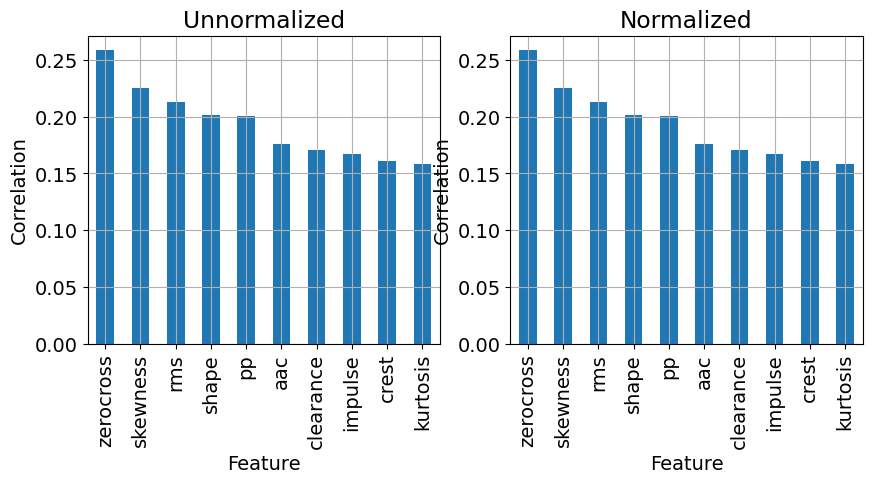

In [7]:
features = extraction.load_features(FEATURES['TD'], ['az'], mafaulda.LABEL_COLUMNS)
features = mafaulda.assign_labels(features, 'A')
features['fault'] = features['label']
columns = [c for c in features.columns if c not in ('label', 'fault')]

fscore = calc_func(features, columns)
features_normalized = normalize_features(features, columns)
fscore_norm = calc_func(features_normalized, columns)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fscore.plot.bar(figsize=(10, 4), grid=True, xlabel='Feature', ylabel=title, legend=False, title='Unnormalized', ax=ax[0])
fscore_norm.plot.bar(figsize=(10, 4), grid=True, xlabel='Feature', ylabel=title, legend=False, title='Normalized', ax=ax[1])
plt.show()

Wavelet packet transform

In [8]:
def features_wavelet_domain(dataset: ZipFile, filename: str, parts: int = PARTS) -> pd.DataFrame:
    return mafaulda.features_by_domain(extraction.wavelet_features_calc, dataset, filename, parts=parts, multirow=True)

In [9]:
if GENERATE is True:
    features = extraction.load_files_split(ZipFile(DATASET_PATH), features_wavelet_domain)
    features.to_csv(FEATURES['WT'])
else:
    features = pd.read_csv(FEATURES['WT'], low_memory=False, index_col=0)

features = features[features['axis'].isin(('ax', 'ay', 'az'))]
features

,fault,severity,seq,rpm,axis,feature,L1_0,L1_1,L2_0,L2_1,...,L6_54,L6_55,L6_56,L6_57,L6_58,L6_59,L6_60,L6_61,L6_62,L6_63
0,horizontal-misalignment,0.5mm,12.288.csv.part.0,716.575981,ax,energy,75114.891950,0.746584,74751.451029,395.020852,...,4.589216e-05,4.973527e-05,4.534998e-05,9.270275e-06,3.726725e-05,8.540088e-05,1.094095e-04,4.585428e-05,5.322645e-04,4.017162e-02
1,horizontal-misalignment,0.5mm,12.288.csv.part.0,716.575981,ax,energy_ratio,0.999990,0.000010,0.994733,0.005257,...,6.075502e-10,6.584277e-10,6.003723e-10,1.227259e-10,4.933680e-10,1.130592e-09,1.448433e-09,6.070486e-10,7.046461e-09,5.318178e-07
2,horizontal-misalignment,0.5mm,12.288.csv.part.0,716.575981,ax,kurtosis,-0.091643,8.810379,-0.098530,2.734838,...,7.656279e+01,7.259536e+00,1.242761e+01,4.015220e+01,1.719114e+01,9.158174e-01,8.219616e-01,1.337483e+00,6.536029e-01,-1.699605e-01
3,horizontal-misalignment,0.5mm,12.288.csv.part.0,716.575981,ax,negentropy,-11.037576,-10.436595,-10.346575,-10.044527,...,-5.353387e+00,-7.081803e+00,-6.874853e+00,-6.094486e+00,-6.772971e+00,-7.400998e+00,-7.408899e+00,-7.369015e+00,-7.447362e+00,-7.595644e+00
4,horizontal-misalignment,0.5mm,12.288.csv.part.0,716.575981,ay,energy,75114.891950,0.746584,74751.451029,395.020852,...,4.589216e-05,4.973527e-05,4.534998e-05,9.270275e-06,3.726725e-05,8.540088e-05,1.094095e-04,4.585428e-05,5.322645e-04,4.017162e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,vertical-misalignment,1.90mm,61.44.csv.part.0,3602.279436,ay,negentropy,-11.062077,-10.946799,-10.370667,-10.044893,...,-7.398361e+00,-7.430870e+00,-7.484350e+00,-7.421728e+00,-7.424175e+00,-7.379950e+00,-7.285133e+00,-7.241961e+00,-7.347055e+00,-7.657506e+00
128,vertical-misalignment,1.90mm,61.44.csv.part.0,3602.279436,az,energy,152717.875315,0.229972,151986.594707,986.534244,...,2.480743e-04,2.106119e-03,1.380193e-03,1.149753e-04,1.723151e-04,2.957165e-04,1.316981e-03,3.875803e-04,3.786365e-04,7.836420e-02
129,vertical-misalignment,1.90mm,61.44.csv.part.0,3602.279436,az,energy_ratio,0.999998,0.000002,0.993549,0.006449,...,1.560078e-09,1.324486e-08,8.679690e-09,7.230511e-10,1.083647e-09,1.859688e-09,8.282165e-09,2.437397e-09,2.381151e-09,4.928130e-07
130,vertical-misalignment,1.90mm,61.44.csv.part.0,3602.279436,az,kurtosis,-0.284283,0.471480,-0.290680,1.385058,...,1.522569e+00,6.935505e-01,3.524344e-01,1.488044e+00,9.403667e-01,9.960404e-01,1.071540e+00,1.449205e+00,1.219575e+00,-5.478439e-01


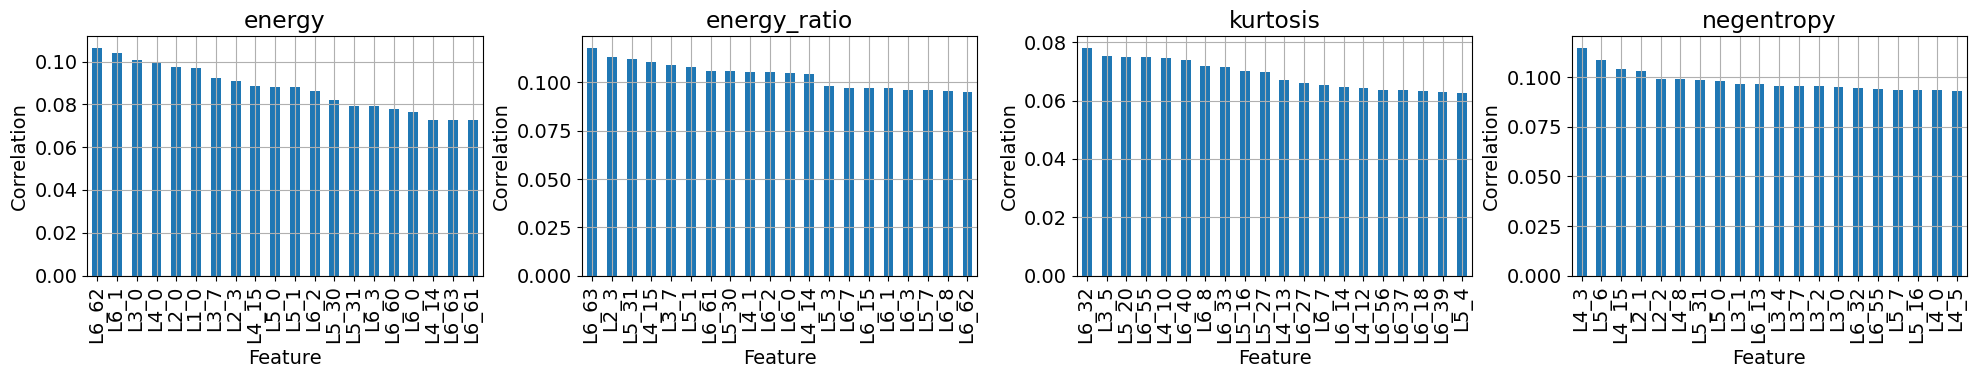

In [10]:
df = calc_score_in_wpd_features(features, calc_func)
plot_fscore_part(df, 'metric', title, n=20)

WPD features in one layer

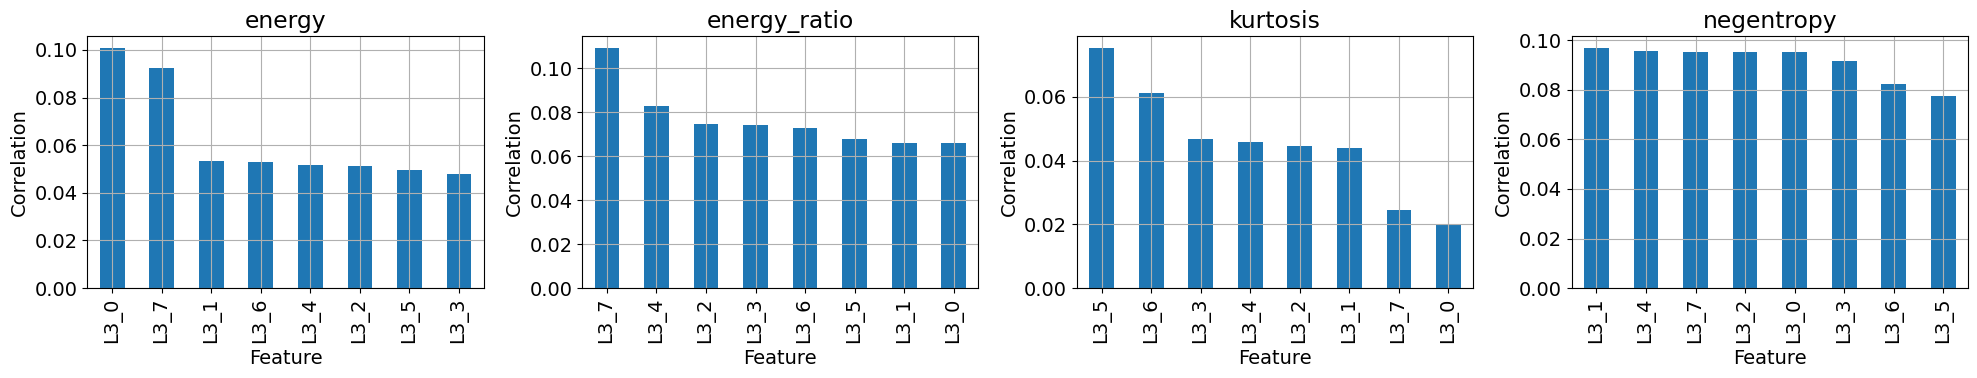

In [11]:
level = 3
df = calc_score_in_wpd_features(features, calc_func)
layer = df[df.index.str.startswith(f'L{level}')]
plot_fscore_part(layer, 'metric', title)

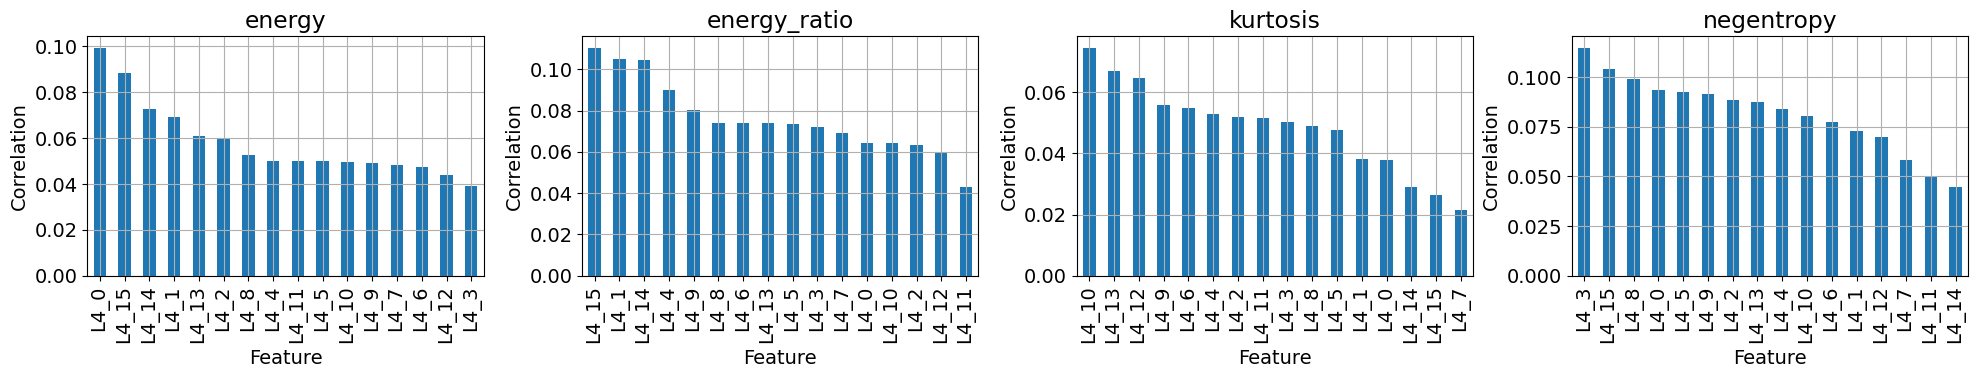

In [12]:
level = 4
df = calc_score_in_wpd_features(features, calc_func)
layer = df[df.index.str.startswith(f'L{level}')]
plot_fscore_part(layer, 'metric', title)

35118


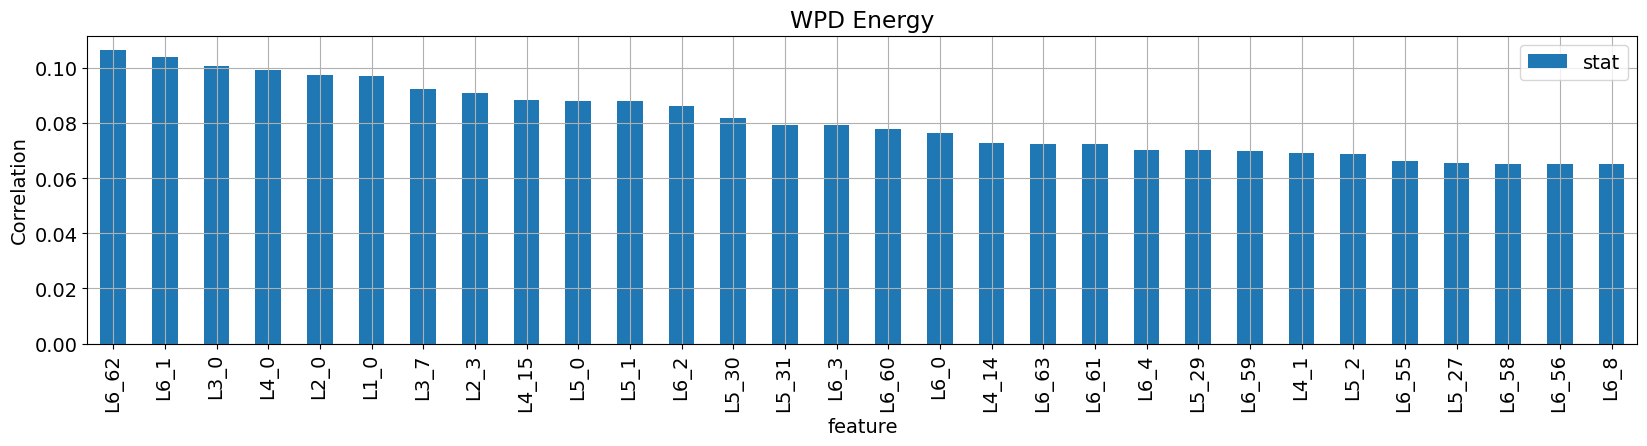

In [13]:
features_energy = features[features['feature'] == 'energy']
columns = list(set(features_energy.columns) - WT_COLUMNS_EXCLUDE)

print(len(features_energy))
mi = calc_func(features_energy, columns)
mi.iloc[:30].plot.bar(figsize=(20, 4), grid=True, ylabel=title, title='WPD Energy')
plt.show()

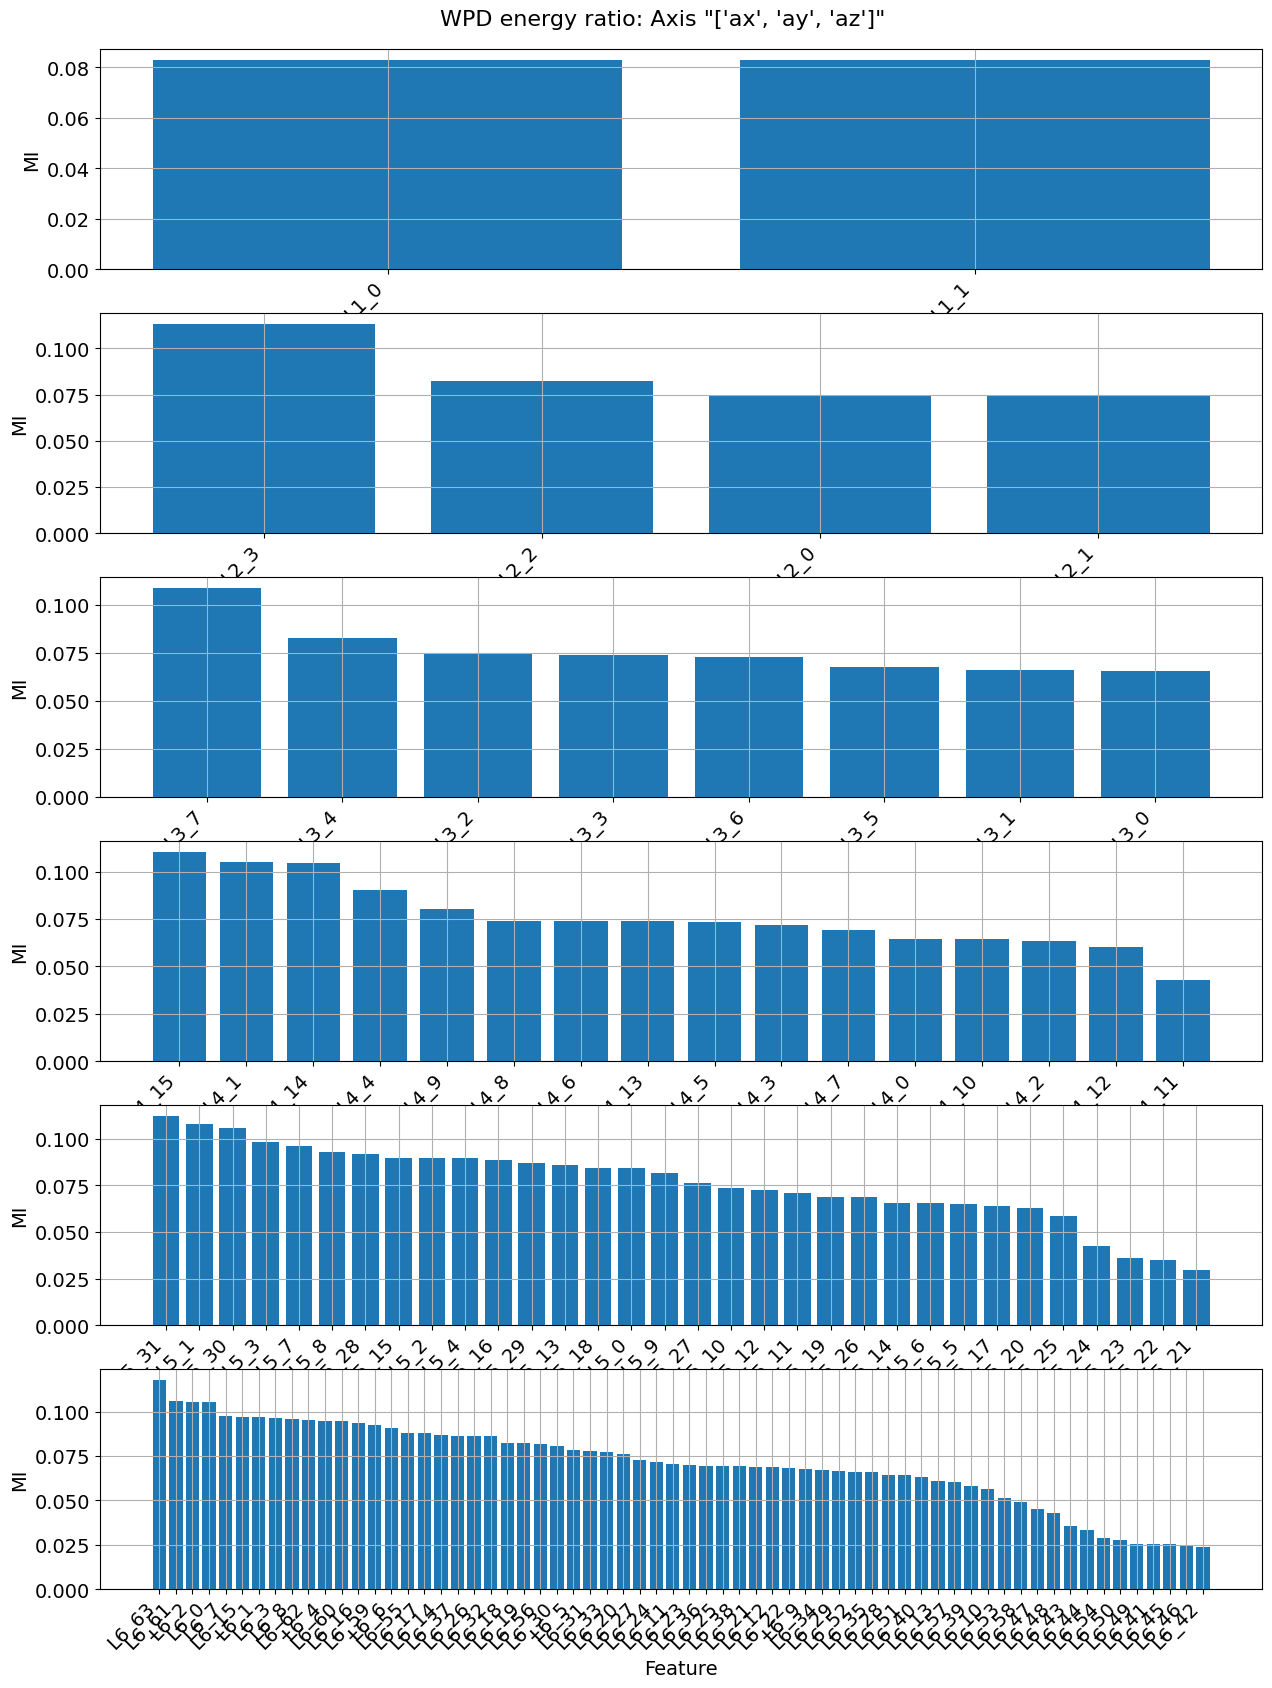

In [14]:
plot_wpd_energy_ratio_per_level(features, ['ax', 'ay', 'az'])

35118


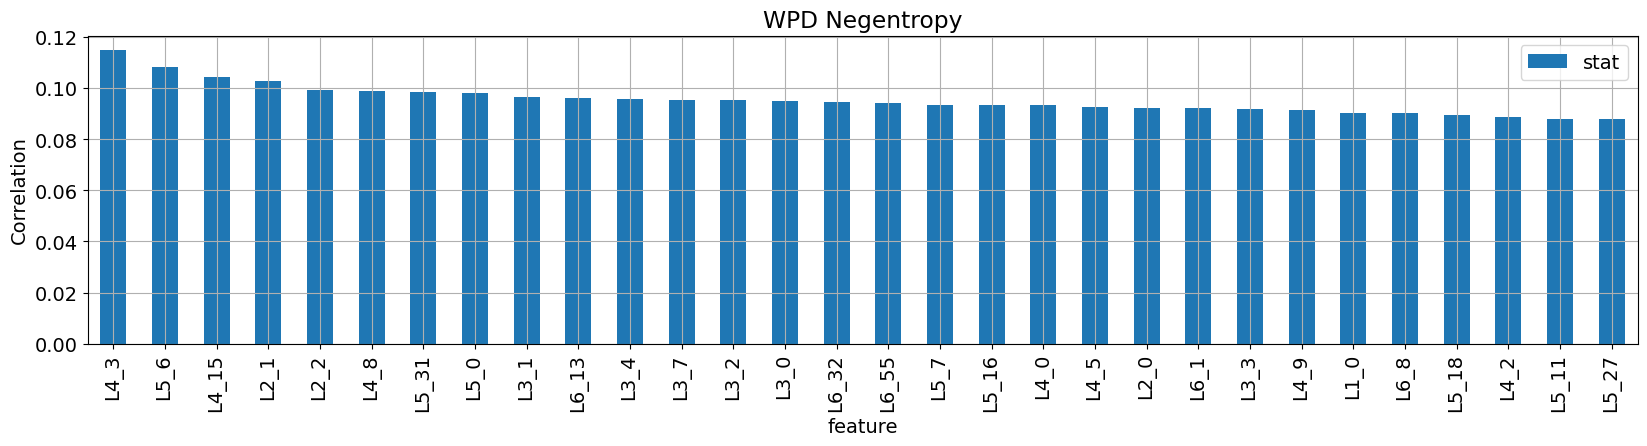

In [15]:
features_entropy = features[features['feature'] == 'negentropy']
columns = list(set(features_entropy.columns) - WT_COLUMNS_EXCLUDE)
print(len(features_entropy))


mi = calc_func(features_entropy, columns)
mi.iloc[:30].plot.bar(figsize=(20, 4), grid=True, ylabel=title, title='WPD Negentropy')
plt.show()

35118


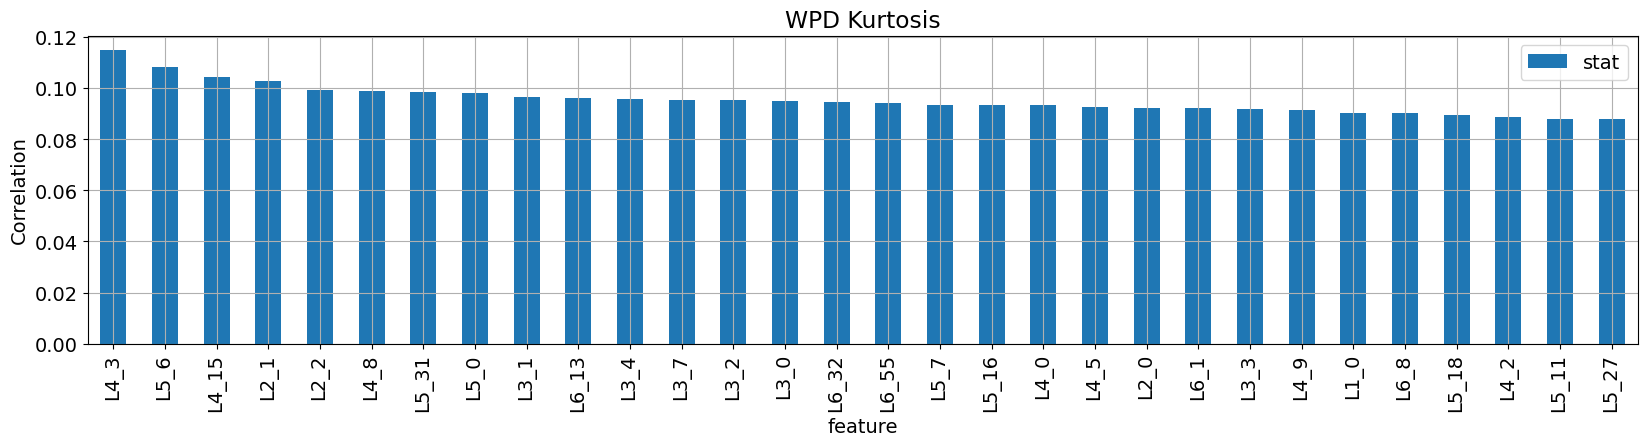

In [16]:
features_kurtosis = features[features['feature'] == 'kurtosis']
columns = list(set(features_energy.columns) - WT_COLUMNS_EXCLUDE)
print(len(features_kurtosis))

mi = calc_func(features_entropy, columns)
mi.iloc[:30].plot.bar(figsize=(20, 4), grid=True, ylabel=title, title='WPD Kurtosis')
plt.show()